# 1.加载数据并检查缺失值

In [1]:
import pandas as pd

df = pd.read_csv('CGSS.csv')
print("数据前五行：")
print(df.head())

print("\n数据信息：")
print(df.info())

# 缺失值统计
print("\n缺失值统计：")
print(df.isnull().sum())


数据前五行：
   id  A2  A3  A7      A8  A15  A16  A18  A58  A61     A62  A69
0   5   2  51   6  300000    5    5    1    1    2  300000    3
1  13   2  34  11   80000    4    5    2    1    2  180000    3
2  15   1  26  10   30000    4    5    4    1    2   80000    3
3  19   2  61   6   36000    4    5    3    5    2   36000    6
4  24   2  61   6   40000    1    3    4    5    2  100000    7

数据信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4791 entries, 0 to 4790
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      4791 non-null   int64
 1   A2      4791 non-null   int64
 2   A3      4791 non-null   int64
 3   A7      4791 non-null   int64
 4   A8      4791 non-null   int64
 5   A15     4791 non-null   int64
 6   A16     4791 non-null   int64
 7   A18     4791 non-null   int64
 8   A58     4791 non-null   int64
 9   A61     4791 non-null   int64
 10  A62     4791 non-null   int64
 11  A69     4791 non-null   int64
dtype

# 2.构建特征工程

In [2]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, KBinsDiscretizer
from sklearn.impute import SimpleImputer

# 自定义对数变换函数
def log_transform(X):
    return np.log1p(X)

# ==================== 数据预处理管道定义 ====================

# 1. 人口统计特征处理
demo_transformer = ColumnTransformer(
    transformers=[
        # 1.1 年龄分箱（数值 -> 分箱 -> 标准化）
        ("age_bin", 
         Pipeline([
             ("imputer", SimpleImputer(strategy="median")),  # 处理缺失值
             ("binning", KBinsDiscretizer(n_bins=5, encode="onehot-dense", strategy="quantile")),
             ("scaler", StandardScaler())
         ]), 
         ["A3"]),
        
        # 1.2 性别（无序分类，1/2 -> 独热编码）
        ("gender", 
         Pipeline([
             ("imputer", SimpleImputer(strategy="most_frequent")),
             ("onehot", OneHotEncoder(categories=[[1, 2]], drop="if_binary", handle_unknown='ignore'))
         ]),  
         ["A2"]),
        
        # 1.3 教育程度（有序数值 -> 标准化）
        ("education", 
         Pipeline([
             ("imputer", SimpleImputer(strategy="median")),
             ("scaler", StandardScaler())
         ]),
         ["A7"]),
        
        # 1.4 婚姻状况（无序分类，1-7 -> 独热编码）
        ("marriage", 
         Pipeline([
             ("imputer", SimpleImputer(strategy="most_frequent")),
             ("onehot", OneHotEncoder(categories=[list(map(str, range(1, 8)))], handle_unknown="ignore"))
         ]), 
         ["A69"]),
        
        # 1.5 户口类型（无序分类，1-6 -> 独热编码）
        ("hukou", 
         Pipeline([
             ("imputer", SimpleImputer(strategy="most_frequent")),
             ("onehot", OneHotEncoder(categories=[list(map(str, range(1, 7)))], handle_unknown="ignore"))
         ]), 
         ["A18"])
    ],
    remainder="passthrough"
)

# 2. 社会经济特征处理
socio_transformer = ColumnTransformer(
    transformers=[
        # 2.1 收入对数变换 + 标准化
        ("income",
         Pipeline([
             ("imputer", SimpleImputer(strategy="median")),
             ("log_transform", StandardScaler())  # 直接在Pipeline中应用对数变换
         ]),
         ["A8", "A62"]),
        
        # 2.2 职业类型（无序分类，1-6 -> 独热编码）
        ("occupation",
         Pipeline([
             ("imputer", SimpleImputer(strategy="most_frequent")),
             ("onehot", OneHotEncoder(categories=[list(map(str, range(1, 7)))], handle_unknown="ignore"))
         ]),
         ["A58"])
    ],
    remainder="passthrough"
)

# 3. 健康状况特征处理
health_transformer = ColumnTransformer(
    transformers=[
        

        # 3.1 自评健康（有序分类，1-5 -> 独热编码）
        ("self_rated_health", 
         Pipeline([
             ("imputer", SimpleImputer(strategy="most_frequent")),
             ("onehot", OneHotEncoder(categories=[[1, 2, 3, 4, 5]], handle_unknown="ignore"))
         ]), 
         ["A15"]),

        # 3.2 生活影响（有序分类，1-5 -> 独热编码）
        ("life_impact", 
         Pipeline([
             ("imputer", SimpleImputer(strategy="most_frequent")),
             ("onehot", OneHotEncoder(categories=[[1, 2, 3, 4, 5]], handle_unknown="ignore"))
         ]), 
         ["A16"]),
    ],
    remainder="passthrough"
)

# ==================== 全局预处理管道 ====================
global_preprocessor = ColumnTransformer(
    transformers=[
        ("demo", demo_transformer, ["A3", "A2", "A7", "A69", "A18"]),
        ("socio", socio_transformer, ["A8", "A62", "A58"]),
        ("health", health_transformer, ["A15", "A16"])
    ],
    verbose_feature_names_out=True  # 保留特征名称
)




# 3.构建模型并进行预测

In [6]:
# 统计每个类别的样本数量
class_counts = df['A61'].value_counts()

# 设置阈值,我们认为小于200的样本数量是太少
threshold = 200

# 筛选掉样本数量小于阈值的类别
classes_to_keep = class_counts[class_counts >= threshold].index
filtered_df = df[df['A61'].isin(classes_to_keep)]

# 确认过滤后的类别分布
print(filtered_df['A61'].value_counts())

# 重新定义特征和目标变量
target = 'A61'
X = filtered_df.drop(columns=[target, 'id'])
y = filtered_df[target]

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 确认训练集中类别分布
print(y_train.value_counts())

A61
1    2179
2    1474
4     978
Name: count, dtype: int64
A61
1    1743
2    1179
4     782
Name: count, dtype: int64



 Training Decision Tree...

 [Decision Tree] Performance
Accuracy: 0.5771
Macro F1-score: 0.5614
              precision    recall  f1-score   support

           1       0.70      0.64      0.67       436
           2       0.47      0.50      0.48       295
           4       0.51      0.56      0.53       196

    accuracy                           0.58       927
   macro avg       0.56      0.57      0.56       927
weighted avg       0.59      0.58      0.58       927



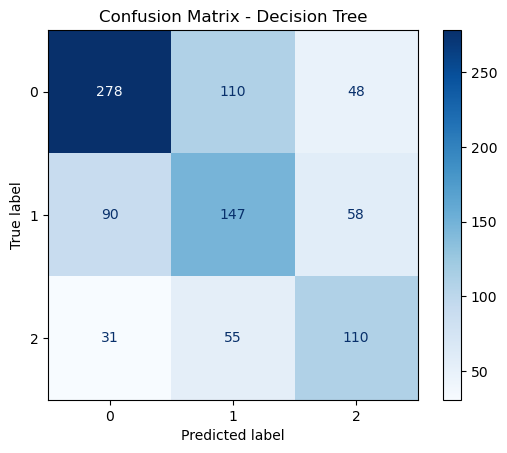


 Training Random Forest...

 [Random Forest] Performance
Accuracy: 0.6505
Macro F1-score: 0.6123
              precision    recall  f1-score   support

           1       0.68      0.86      0.76       436
           2       0.56      0.41      0.47       295
           4       0.68      0.55      0.61       196

    accuracy                           0.65       927
   macro avg       0.64      0.61      0.61       927
weighted avg       0.64      0.65      0.63       927



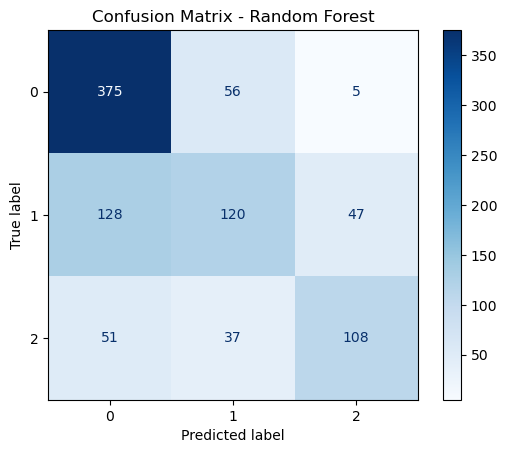


 Training Neural Network...

 [Neural Network] Performance
Accuracy: 0.6192
Macro F1-score: 0.5744
              precision    recall  f1-score   support

           1       0.68      0.83      0.74       436
           2       0.51      0.42      0.46       295
           4       0.61      0.45      0.52       196

    accuracy                           0.62       927
   macro avg       0.60      0.57      0.57       927
weighted avg       0.61      0.62      0.61       927



/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


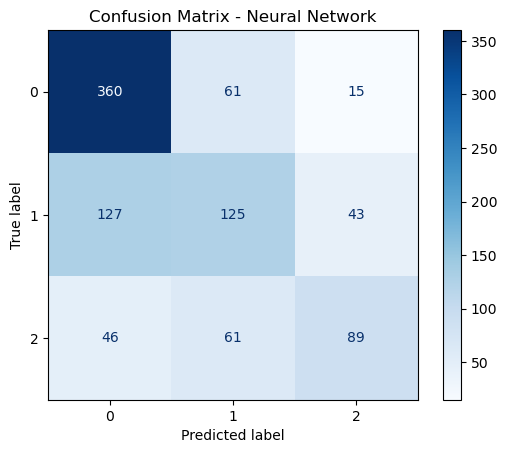


 Best model: Random Forest with accuracy = 0.6505


In [7]:
# 导入常用库
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


# 类别权重（建议：自动平衡）
class_weight = "balanced"

# 存储结果用字典
results = {}

# 模型列表 - 现在使用Pipeline将特征工程和模型组合
models = {
    "Decision Tree": Pipeline([
        ('preprocessor', global_preprocessor),
        ('classifier', DecisionTreeClassifier(class_weight=class_weight, random_state=42))
    ]),
    "Random Forest": Pipeline([
        ('preprocessor', global_preprocessor),
        ('classifier', RandomForestClassifier(class_weight=class_weight, random_state=42, n_jobs=-1))
    ]),
    "Neural Network": Pipeline([
        ('preprocessor', global_preprocessor),
        ('classifier', MLPClassifier(random_state=42, max_iter=500))
    ])
}

# 模型训练 & 评估
for name, pipeline in models.items():
    print(f"\n Training {name}...")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")
    cm = confusion_matrix(y_test, y_pred)

    results[name] = {
        "pipeline": pipeline,
        "accuracy": acc,
        "f1_macro": f1,
        "conf_matrix": cm
    }

    print(f"\n [{name}] Performance")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1-score: {f1:.4f}")
    print(classification_report(y_test, y_pred))

    # 混淆矩阵图
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

# 找出最优模型
best_model_name, best_model_info = max(results.items(), key=lambda x: x[1]["accuracy"])
print(f"\n Best model: {best_model_name} with accuracy = {best_model_info['accuracy']:.4f}")



 Feature Importances Analysis:
                             Feature  Importance
21                socio__income__A62    0.177215
20                 socio__income__A8    0.155563
6                demo__education__A7    0.116833
14                demo__hukou__A18_1    0.099136
5                 demo__gender__A2_2    0.033897
15                demo__hukou__A18_2    0.024383
31  health__self_rated_health__A15_4    0.023745
37        health__life_impact__A16_5    0.022661
16                demo__hukou__A18_3    0.022399
36        health__life_impact__A16_4    0.021038


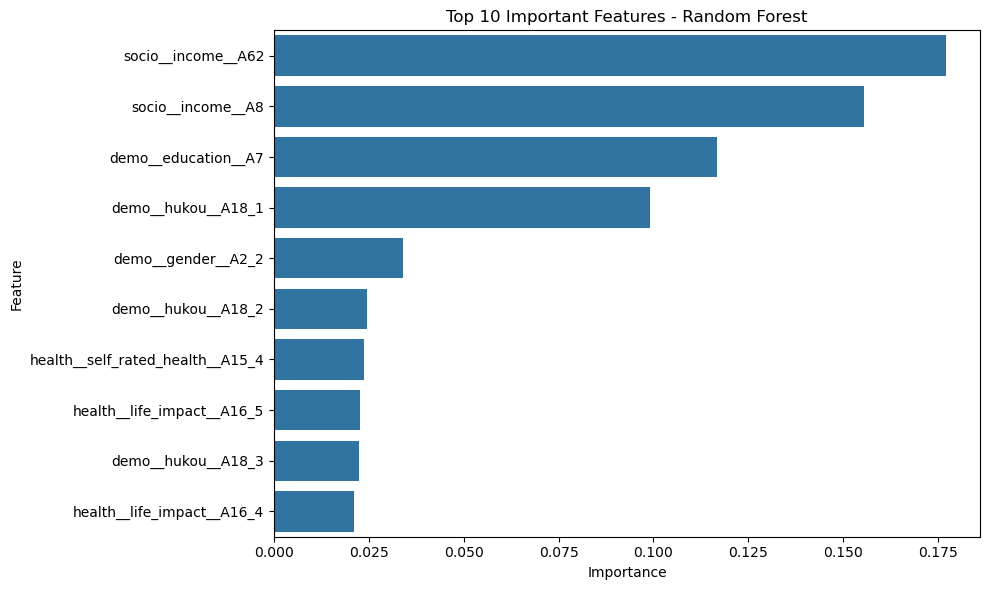


 Saved best model to best_model_random_forest.pkl


In [8]:

# 特征重要性分析（仅适用于树模型）
if hasattr(best_model_info['pipeline'].named_steps['classifier'], 'feature_importances_'):
    print("\n Feature Importances Analysis:")
    
    # 获取特征名称
    feature_names = best_model_info['pipeline'].named_steps['preprocessor'].get_feature_names_out()
    
    # 获取重要性分数
    importances = best_model_info['pipeline'].named_steps['classifier'].feature_importances_
    
    # 创建DataFrame展示
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    print(importance_df.head(10))
    
    # 可视化
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
    plt.title(f'Top 10 Important Features - {best_model_name}')
    plt.tight_layout()
    plt.show()

# 保存最佳模型
import joblib
best_model_filename = f"best_model_{best_model_name.replace(' ', '_').lower()}.pkl"
joblib.dump(best_model_info['pipeline'], best_model_filename)
print(f"\n Saved best model to {best_model_filename}")

In [9]:
# 交叉模型验证

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}


grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='roc_auc_ovr',  
    n_jobs=-1  
)

grid_search.fit(X_train, y_train)

print("随机森林最优参数：", grid_search.best_params_)
print("最优模型 ROC-AUC：", grid_search.best_score_)

随机森林最优参数： {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
最优模型 ROC-AUC： 0.8082819583729137


# 4.构建模型管道

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import joblib

# 构建管道
model= Pipeline([
    ('preprocessor', global_preprocessor),  # 你的特征工程
    ('classifier', RandomForestClassifier(n_estimators=200, class_weight='balanced'))
])

# 训练
model.fit(X_train, y_train)




Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('demo',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('age_bin',
                                                                                   Pipeline(steps=[('imputer',
                                                                                                    SimpleImputer(strategy='median')),
                                                                                                   ('binning',
                                                                                                    KBinsDiscretizer(encode='onehot-dense')),
                                                                                                   ('scaler',
                                                                                                    StandardScaler())]),
                                                                                   ['A3']),
                                                                                  ('gender',
                                                                                   Pipeline(steps=[('imputer',
                                                                                                    SimpleImputer(strategy=...
                                                                                                   ('onehot',
                                                                                                    OneHotEncoder(categories=[[1,
                                                                                                                               2,
                                                                                                                               3,
                                                                                                                               4,
                                                                                                                               5]],
                                                                                                                  handle_unknown='ignore'))]),
                                                                                   ['A15']),
                                                                                  ('life_impact',
                                                                                   Pipeline(steps=[('imputer',
                                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                                   ('onehot',
                                                                                                    OneHotEncoder(categories=[[1,
                                                                                                                               2,
                                                                                                                               3,
                                                                                                                               4,
                                                                                                                               5]],
                                                                                                                  handle_unknown='ignore'))]),
                                                                                   ['A16'])]),
                                                  ['A15', 'A16'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=2

# 5.可视化分析

/var/folders/2s/f7fc9t5n6ln0h62x2t_q79v80000gn/T/ipykernel_80184/4191549244.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Dark2', n_classes)


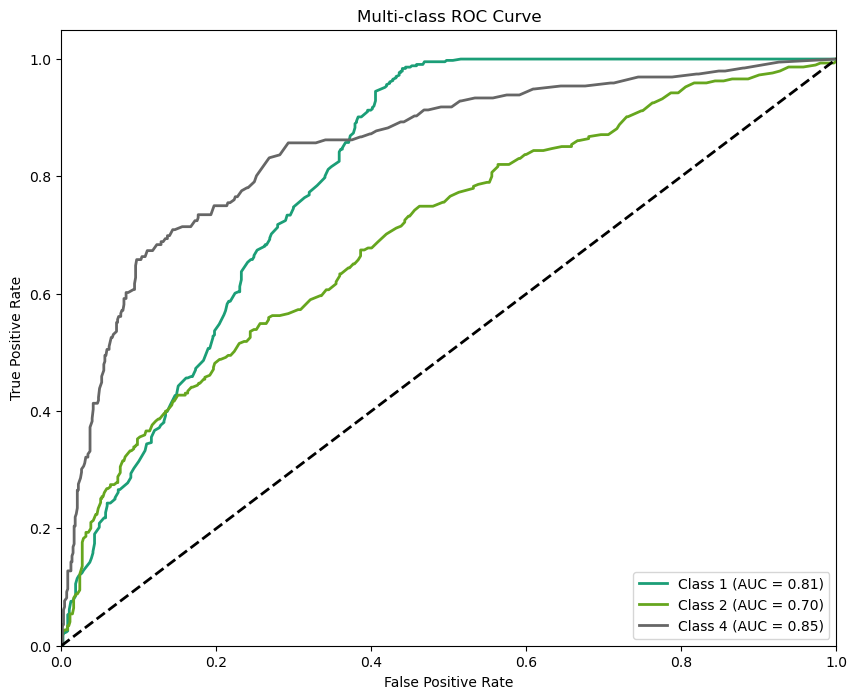

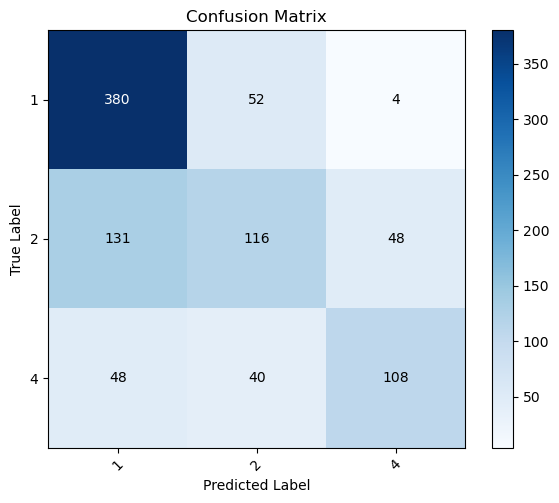

              precision    recall  f1-score   support

           1       0.68      0.87      0.76       436
           2       0.56      0.39      0.46       295
           4       0.68      0.55      0.61       196

    accuracy                           0.65       927
   macro avg       0.64      0.61      0.61       927
weighted avg       0.64      0.65      0.63       927



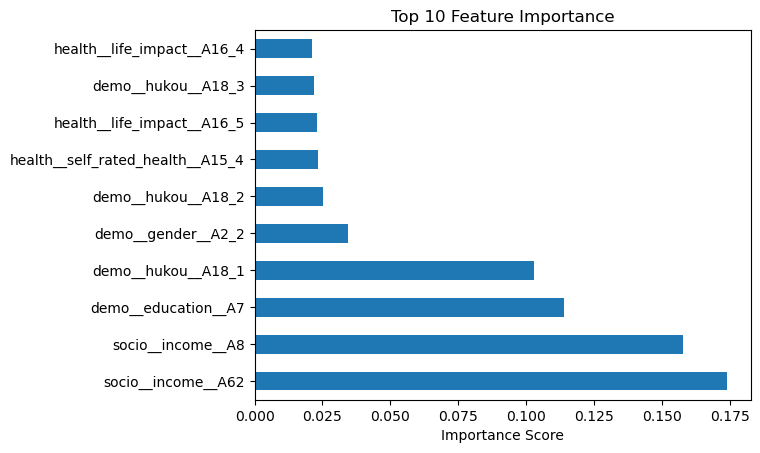


 [Neural Network] Performance
Accuracy: 0.6516
Macro F1-score: 0.6106
              precision    recall  f1-score   support

           1       0.68      0.87      0.76       436
           2       0.56      0.39      0.46       295
           4       0.68      0.55      0.61       196

    accuracy                           0.65       927
   macro avg       0.64      0.61      0.61       927
weighted avg       0.64      0.65      0.63       927



In [11]:

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize


# 1. 多分类 ROC 曲线
# 首先将 y_test 二值化（one-vs-rest），假设类别为 y_test 中出现的所有唯一值
classes = np.unique(y_test)
y_test_binarized = label_binarize(y_test, classes=classes)
n_classes = y_test_binarized.shape[1]

# 修正：使用整个pipeline获取预测概率（会自动应用特征工程）
y_score = model.predict_proba(X_test)  # 关键修改

# 对每个类别计算 ROC 曲线和 AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制每个类别的 ROC 曲线
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('Dark2', n_classes)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i],
             color=colors(i),
             lw=2,
             label=f'Class {classes[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.show()

# 2. 绘制混淆矩阵
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
# 添加每个格子的数字
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()

# 打印分类报告
print(classification_report(y_test, y_pred))

# 3. 绘制特征重要性图
try:
    # 获取预处理后的特征名称
    preprocessed_features = model.named_steps["preprocessor"].get_feature_names_out()
    
    # 获取特征重要性
    feature_importance = model.named_steps["classifier"].feature_importances_
    feat_imp_series = pd.Series(feature_importance, index=preprocessed_features)
    
    # 绘制前N个重要特征
    top_n = min(10, len(feat_imp_series))  # 确保不超过特征总数
    feat_imp_series.nlargest(top_n).plot(kind='barh')
    plt.title("Top {} Feature Importance".format(top_n))
    plt.xlabel("Importance Score")
    plt.show()
    
except AttributeError:
    print("Warning: Preprocessor does not support get_feature_names_out(). Cannot plot feature importance.")

# 输出评估结果
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="macro")
cm = confusion_matrix(y_test, y_pred)

results[name] = {
    "pipeline": pipeline,
    "accuracy": acc,
    "f1_macro": f1,
    "conf_matrix": cm
}

print(f"\n [{name}] Performance")
print(f"Accuracy: {acc:.4f}")           
print(f"Macro F1-score: {f1:.4f}")      
print(classification_report(y_test, y_pred))

# 6.模型预测操作

In [13]:
import pandas as pd

def get_user_input():
    data = {}
    print("请输入以下信息，以帮助预测您的医疗保险类型：\n")
    
    # 人口统计特征
    try:
        data["A3"] = float(input("年龄 (请输入您的年龄)："))
    except ValueError:
        data["A3"] = 0  # 默认值
    try:
        data["A2"] = input("性别 (请输入 1:男，2:女): ")
    except ValueError:
        data["A2"] = 0  # 默认值
    try:
        data["A7"] = float(input("教育程度 (请输入 1:从未受过教育，2:扫盲班，3:小学，4:初中，5:职业高中，6:普通高中，7:中专，8:技校，9:大学专科（成人教育），10:大学专科（正规教育），11:大学本科（成人教育），12:大学本科（正规教育），13:研究生及以上)：："))
    except ValueError:
        data["A7"] = 0  # 默认值
    data["A69"] = input("婚姻状况 (请输入 1:未婚，2:同居，3:初婚有配偶，4:丧偶，5:再婚有配偶，6:分居未离婚，7:离婚，8:丧偶)：")
    data["A18"] = input("户口类型 (请输入 1:农业，2:非农业，3:居民（从前是农业），4:居民(从前是非农），5:军籍，6:无户口)：")
    
    # 社会经济特征
    try:
        data["A8"] = float(input("个人年收入 (请输入您的年收入，例如 50000)："))
    except ValueError:
        data["A8"] = 0  # 默认值
    try:
        data["A62"] = float(input("家庭年收入 (请输入您的家庭年收入，例如 100000)："))
    except ValueError:
        data["A62"] = 0  # 默认值
    data["A58"] = input("工作状况 (请输入1:目前从事非农工作，2:目前务农，曾经有过非农工作，3:目前务农，没有非农工作，4:目前没有工作，而且只务过农，5:目前没有工作，曾经有过非农工作，6:从未工作过)：")
    
    # 健康状况特征
    try:
        data["A15"] = float(input("自评健康状况 (请输入 1:很不健康，2:比较不健康，3:一般，4:比较健康，5:很健康)："))
    except ValueError:
        data["A15"] = 0  # 默认值
    try:
        data["A16"] = float(input("自评健康问题影响生活程度 (请输入 1:总是，2:经常，3:有时，4:很少，5:从不)："))
    except ValueError:
        data["A16"] = 0  # 默认值
    
    # 将字典转换为 DataFrame
    df_input = pd.DataFrame([data])
    return df_input

# 获取用户输入数据
user_data = get_user_input()

# 确保 user_data 包含所有必要的特征
print(user_data)  # 可以调试时查看数据

# 使用模型进行预测
try:
    prediction = model.predict(user_data)
    prediction_proba = model.predict_proba(user_data)

    print("\n预测的类别为:", prediction)
    print("只有公共医疗保险、公共和商业医疗保险都有、没有医疗保险概率分别为:")
    print(prediction_proba)
except ValueError as e:
    print("预测时出现错误:", e)

请输入以下信息，以帮助预测您的医疗保险类型：

     A3 A2    A7 A69 A18        A8       A62 A58  A15  A16
0  25.0  2  13.0   1   2  120000.0  300000.0   1  4.0  5.0

预测的类别为: [1]
只有公共医疗保险、公共和商业医疗保险都有、没有医疗保险概率分别为:
[[0.55 0.33 0.12]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
